In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import model as m
import os
import seaborn as sns
from math import sqrt
from scipy import stats
from pydataset import data
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Wrangaling the data

In [2]:
df= pd.read_csv('dnd_stats.csv')
df

,race,height,weight,speed,strength,dexterity,constitution,intelligence,wisdom,charisma
0,dragonborn,71,195,30,14,15,12,7,13,16
1,dragonborn,75,193,30,11,11,11,13,13,17
2,dragonborn,73,252,30,14,16,11,13,10,18
3,dragonborn,75,256,30,8,19,7,10,13,16
4,dragonborn,71,205,30,8,17,14,14,10,9
...,...,...,...,...,...,...,...,...,...,...
9995,tiefling,66,146,30,13,18,17,13,15,13
9996,tiefling,69,134,30,8,14,13,6,14,20
9997,tiefling,69,194,30,4,5,16,12,12,15
9998,tiefling,70,214,30,12,16,12,15,9,16


In [3]:
df.isna().sum()

race            0
height          0
weight          0
speed           0
strength        0
dexterity       0
constitution    0
intelligence    0
wisdom          0
charisma        0
dtype: int64

In [4]:
def get_dnd():
    
    '''
    This function is used to acquire the dnd_stats.csv from the local file. If the file does not already exist,
    the function will create the file.
    ''' 
    
    if os.path.isfile('dnd_stats.csv'):
        
        return pd.read_csv('dnd_stats.csv')
    
    else:
        
        df = pd.read_csv("dnd_stats.csv")
    
        return df  
df= get_dnd()

In [5]:
df.dtypes

race            object
height           int64
weight           int64
speed            int64
strength         int64
dexterity        int64
constitution     int64
intelligence     int64
wisdom           int64
charisma         int64
dtype: object

In [6]:
dummy_df = pd.get_dummies(df[['race']],
                              drop_first=True)
df = pd.concat( [df, dummy_df], axis=1 )
    

In [7]:
df.rename(columns= {'race_half.elf': 'race_half_elf', 'race_half.orc': 'race_half_orc'}, inplace= True)

In [8]:
def the_split(df, stratify= None):

    """ This functions is used to split the data into 3 different datasets: train, validate(val), and test.
        It then then returns the seperate datasets and prints the shape for each of them.
    """
        
    # train/validate/test split and is reproducible due to random_state = 123
    train_validate, test= train_test_split(df, test_size= .2, random_state= 7)
    train, val= train_test_split(train_validate, test_size= .3, random_state= 7)
    
    print(f'Train shape: {train.shape}\n' )
    
    print(f'Validate shape: {val.shape}\n' )
    
    print(f'Test shape: {test.shape}')
    
    return train, val, test
train, val, test= the_split(df)

Train shape: (5600, 18)

Validate shape: (2400, 18)

Test shape: (2000, 18)


# Exploration 

# Q1: Do characters who have a higher stat of height or weight have a higher wisdom stat?

In [17]:
def get_tl_boy(train):
    tall_boy= train[train.height > 75]
    large_boy= train[train.weight > 280]
    tl_boy= pd.concat([tall_boy, large_boy])
    tl_wis= tl_boy.wisdom
    
    overall= train.wisdom.mean()
    return tl_boy, tl_wis, overall
tl_boy, tl_wis, overall= get_tl_boy(train)

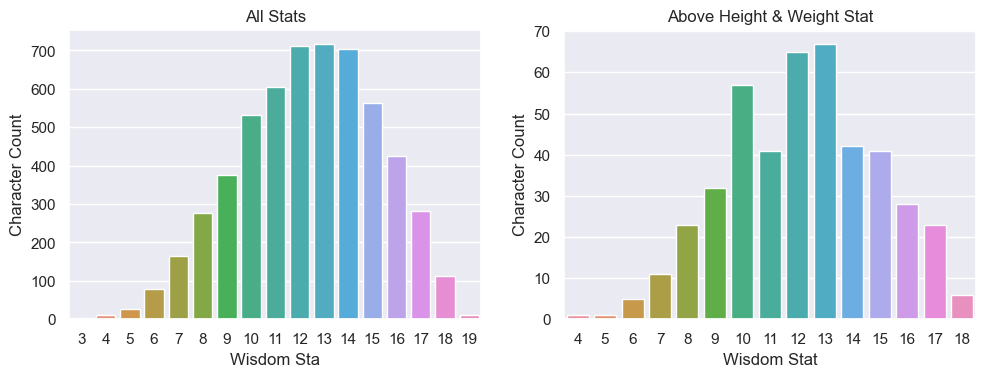

In [18]:
def plot_above(train, tl_boy):
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    fig = plt.figure()
    ax = fig.add_subplot(221)
    sns.countplot(data= train, x= 'wisdom')

    ax.set_xlabel('Wisdom Sta', fontsize = 12)
    ax.set_ylabel('Character Count', fontsize = 12)
    ax.set_title('All Stats', fontsize = 12)

    ax = fig.add_subplot(222)
    sns.countplot(data= tl_boy, x= 'wisdom')
    ax.set_xlabel('Wisdom Stat', fontsize = 12)
    ax.set_ylabel('Character Count', fontsize = 12)
    ax.set_title('Above Height & Weight Stat', fontsize = 12)
    plt.show()
plot_above(train, tl_boy)

$H_o$: Characters who have a have greater height and weight, have a higher wisdom stat compared to the other races.

$H_a$: Characters who have a have greater height and weight, do not a higher wisdom stat compared to the other races.


In [23]:
def the_t(train, tl_wis):
    alpha = 0.5
    overall= train.wisdom.mean()
    
    t, p = stats.ttest_1samp(tl_wis, overall)

    if p/2 > alpha:
        print("We fail to reject the Null Hypothesis")
    elif t < 0:
        print("We fail to reject the Null Hypothesis")
    else:
        print("We reject the Null Hypothesis")
the_t(train, tl_wis)

We fail to reject the Null Hypothesis


# Takeawakys: 
  - Based on the graph we are not able to clearly tell apart which group has a greater wisdom. However, based on the results from our statistical testing, we are able to see that charcters who have a high height and weight count, do have a higher wisdom.

# Q2: Do characters having above average stats have higher wisdom?

In [25]:
def get_above(train):
    
    above_height= train[train.height > 60]
    above_weight= train[train.weight > 145]
    above_speed= train[train.speed > 28]
    above_strength= train[train.strength > 13]
    above_dex= train[train.dexterity > 13]
    above_constitution= train[train.constitution > 13]
    above_intelligence= train[train.intelligence > 13]
    above_charisma= train[train.charisma > 13]
    
    above_df= pd.concat([above_charisma, above_constitution, above_dex, above_height, above_intelligence,
                   above_speed, above_weight, above_strength])
    
    above_wis= above_df.wisdom
    
    overall= train.wisdom.mean()
    return above_df, above_wis, overall
above_df, above_wis, overall= get_above(train)

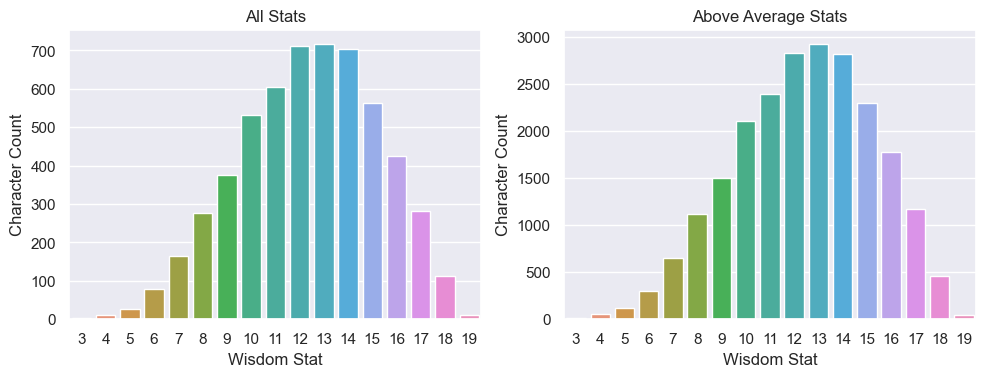

In [26]:
def plot_above(train, above_df):
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    fig = plt.figure()
    ax = fig.add_subplot(221)
    sns.countplot(data= train, x= 'wisdom')

    ax.set_xlabel('Wisdom Stat', fontsize = 12)
    ax.set_ylabel('Character Count', fontsize = 12)
    ax.set_title('All Stats', fontsize = 12)

    ax = fig.add_subplot(222)
    sns.countplot(data= above_df, x= 'wisdom')
    ax.set_xlabel('Wisdom Stat', fontsize = 12)
    ax.set_ylabel('Character Count', fontsize = 12)
    ax.set_title('Above Average Stats', fontsize = 12)
    plt.show()
plot_above(train, above_df)

$H_o$: The characters who have above average stats have equal, or less, wisdom stats.

$H_a$: The characters who have above average stats have higher wisdom stats.

In [27]:
def test_above(above_wis, overall):
    alpha= 0.5
    t, p = stats.ttest_1samp(above_wis, overall)

    if p/2 > alpha:
        print("We fail to reject the Null Hypothesis")
    elif t < 0:
        print("We fail to reject the Null Hypothesis")
    else:
        print("We reject the Null Hypothesis")
test_above(above_wis, overall)

We reject the Null Hypothesis


# Takeaways:
  - Both the graph show and the statistical testing show us that characters with above average stats have a higher wisdom.

# Q3: Do characters having both high intelligence and dexterity have greater wisdom?

In [25]:
big_smart= train[train.intelligence > 16]
big_brain= big_smart[big_smart.dexterity > 16]

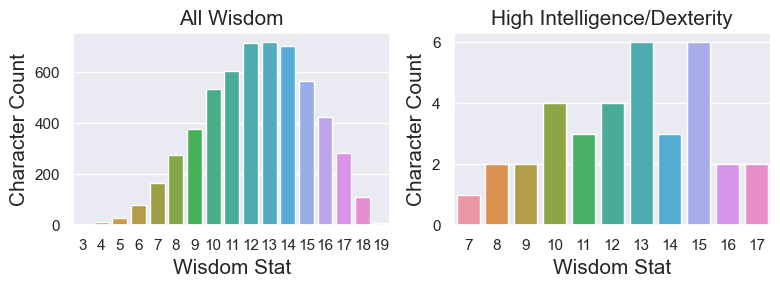

In [124]:
def plot_big_brain():
    fig = plt.figure()
    ax1 = fig.add_subplot(223)
    sns.countplot(data= train, x= 'wisdom')

    ax1.set_xlabel('Wisdom Stat', fontsize = 15)
    ax1.set_ylabel('Character Count', fontsize = 15)
    ax1.set_title('All Wisdom', fontsize = 15)

    ax2 = fig.add_subplot(224)
    sns.countplot(data= big_brain, x= 'wisdom')
    ax2.set_xlabel('Wisdom Stat', fontsize = 15)
    ax2.set_ylabel('Character Count', fontsize = 15)
    ax2.set_title('High Intelligence/Dexterity', fontsize = 15)
    plt.show()
plot_big_brain()

# Q4: Does being a certain race mean higher wisdom?

In [27]:
dragonborn_wis= train[train.race== 'dragonborn'].wisdom.mean()
halfling_wis= train[train.race== 'halfling'].wisdom.mean()
gnome_wis= train[train.race== 'gnome'].wisdom.mean()
human_wis= train[train.race== 'human'].wisdom.mean()
tiefling_wis= train[train.race== 'tiefling'].wisdom.mean()
elf_wis= train[train.race== 'elf'].wisdom.mean()
dwarf_wis= train[train.race== 'dwarf'].wisdom.mean()
half_elf_wis= train[train.race== 'half.elf'].wisdom.mean()
half_orc= train[train.race== 'half.orc'].wisdom.mean()

In [28]:
wis_avg= pd.DataFrame({'dragonborn': dragonborn_wis,
              'halfling': halfling_wis,
              'gnome': gnome_wis,
              'human': human_wis,
              'tiefling': tiefling_wis,
              'elf': elf_wis,
              'dwarf': dwarf_wis,
              'half_elf': half_elf_wis,
              'half_orc': half_orc}, index= [0])

In [29]:
wis_mean= pd.DataFrame(train.groupby('race')['wisdom'].mean()).reset_index()

In [30]:
wis_mean

,race,wisdom
0,dragonborn,12.093702
1,dwarf,12.128165
2,elf,12.260434
3,gnome,12.221338
4,half.elf,12.624788
5,half.orc,12.123779
6,halfling,12.425868
7,human,13.252475
8,tiefling,12.366306


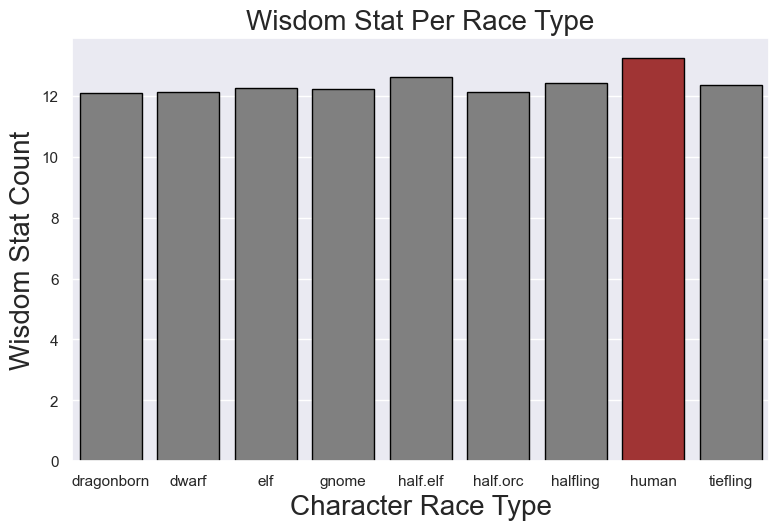

In [108]:
def wis_per_race(wis_mean):
    color= ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey','firebrick']
    fig = plt.figure()
    sns.barplot(data= wis_mean, y= 'wisdom', x= 'race', palette= color, ec= 'black')
    sns.set(rc={'figure.figsize':(9.0, 5.50)})
    plt.xlabel('Character Race Type', fontsize = 20)
    plt.ylabel('Wisdom Stat Count', fontsize = 20)
    plt.title('Wisdom Stat Per Race Type', fontsize = 20)

    plt.show()
wis_per_race(wis_mean)

# Modeling 

In [32]:
def clustering(train, f1, f2):
    '''
    This function is creating unscaled and scaled clusters and adding columns to the dataset
    '''
    
    seed = 22
    
    X = train[[f1, f2]]
    
    kmeans = KMeans(n_clusters = 4, random_state= seed)
    kmeans.fit(X)
    kmeans.predict(X)

    X['unscaled_clusters'] = kmeans.predict(X)
    
    mm_scaler = MinMaxScaler()
    X[[f1, f2]] = mm_scaler.fit_transform(X[[f1, f2]])
    
    kmeans_scale = KMeans(n_clusters = 4, random_state = 22)
    kmeans_scale.fit(X[[f1, f2]])
    kmeans_scale.predict(X[[f1, f2]])
    
    X['scaled_clusters'] = kmeans_scale.predict(X[[f1, f2]])
    
    return X   
clusters= clustering(train, 'charisma', 'constitution')
clusters

,charisma,constitution,unscaled_clusters,scaled_clusters
4099,0.705882,0.705882,1,3
9839,0.764706,0.529412,3,0
2558,0.352941,0.588235,2,2
7552,0.352941,0.764706,2,1
8851,0.470588,0.764706,2,1
...,...,...,...,...
6397,0.588235,0.705882,2,3
3938,0.294118,0.882353,2,1
9664,0.470588,0.647059,2,1
5731,0.235294,0.882353,2,1


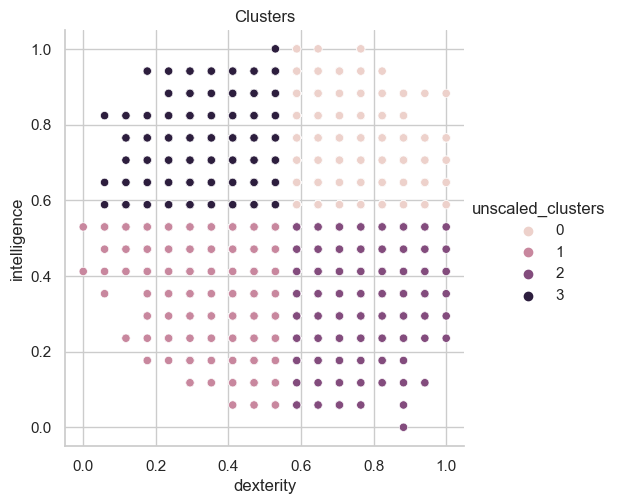

In [33]:
def cluster_relplot(df, f1, f2):
    '''
    This functions creates a relplot of the clusters
    '''
    
    sns.set(style = "whitegrid")
    
    X = clustering(df, f1, f2)
    
    sns.relplot(data = X, x = f1, y = f2, hue = 'unscaled_clusters')
    
    plt.title('Clusters')
    
    return plt.show() 
cluster_relplot(train, 'dexterity', 'intelligence')

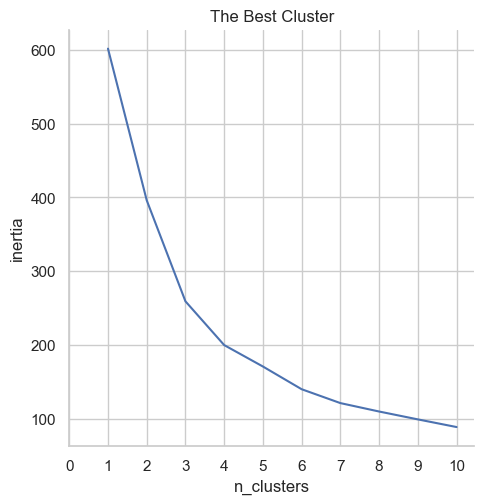

In [34]:
def best_cluster(df, f1, f2):
    '''
    This function makes a graph to show the most optimal cluster number
    '''
    
    X = clustering(df, f1, f2)
    
    inertia = []
    seed = 22 

    for n in range(1,11):

        kmeans = KMeans(n_clusters = n, random_state = seed)

        kmeans.fit(X[[f1, f2]])

        inertia.append(kmeans.inertia_)
        
        
    results_df = pd.DataFrame({'n_clusters': list(range(1,11)),
                               'inertia': inertia})   
    
    sns.set_style("whitegrid")
    sns.relplot(data = results_df, x='n_clusters', y = 'inertia', kind = 'line')
    plt.xticks(np.arange(0, 11, step=1))
    point = (3, 107) # specify the x and y values of the point to annotate
   # plt.annotate("optimal cluster", xy=point, xytext=(5, 125), 
                 #arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.title('The Best Cluster')
    
    return plt.show()
best_cluster(df, 'charisma', 'constitution')

In [35]:
def combined_df(df, f1, f2):
    
    X = clustering(df, f1, f2)
    
    scaled_clusters = X['scaled_clusters']
    df3 = pd.merge(df, scaled_clusters, left_index=True, right_index=True)
    
    return df3
df= combined_df(df, 'dexterity', 'intelligence')

In [36]:
train, val, test= the_split(df)

Train shape: (5600, 19)

Validate shape: (2400, 19)

Test shape: (2000, 19)


train_scaled.drop(columns= ['scaled_clusters_y'], inplace= True)
val_scaled.drop(columns= ['scaled_clusters_y'], inplace= True)
test_scaled.drop(columns= ['scaled_clusters_y'], inplace= True)

train_scaled.rename(columns= {'scaled_clusters_x': 'scaled_clusters'}, inplace= True)
val_scaled.rename(columns= {'scaled_clusters_x': 'scaled_clusters'}, inplace= True)
test_scaled.rename(columns= {'scaled_clusters_x': 'scaled_clusters'}, inplace= True)

In [40]:
df.drop(columns= ['race'], inplace= True)

In [41]:
train, val, test= the_split(df)

Train shape: (5600, 18)

Validate shape: (2400, 18)

Test shape: (2000, 18)


In [42]:
def mvp_scaled_data(train, val, test, return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    train.drop(columns= ['wisdom'], inplace= True)
    columns_scale = train.iloc[:, :16]
    columns_to_scale = columns_scale.columns
    
    train, val, test= the_split(df)
    
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    val_scaled = val.copy()
    test_scaled = test.copy()
    #     make the thing
    mms = MinMaxScaler()
    #     fit the thing
    mms.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(mms.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    val_scaled[columns_to_scale] = pd.DataFrame(mms.transform(val[columns_to_scale]), 
                                                     columns=val[columns_to_scale].columns.values).set_index([val.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(mms.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, val_scaled, test_scaled
train_scaled, val_scaled, test_scaled= mvp_scaled_data(train, val, test)

Train shape: (5600, 18)

Validate shape: (2400, 18)

Test shape: (2000, 18)


In [44]:
train, val, test= the_split(df)

Train shape: (5600, 18)

Validate shape: (2400, 18)

Test shape: (2000, 18)


In [52]:
def six_split(train, val, test, target):
    """
    this functions splits the data into 6 different datasets. We will use them for 
    our modeling 
    """
    # split into X and y train dataset 
    X_train= train.drop(columns=[target])
    y_train= train[target]

    # split into X and y val dataset 
    X_val= val.drop(columns=[target])
    y_val= val[target]

    # split into X and y test dataset 
    X_test= test.drop(columns=[target])
    y_test= test[target]

    X_train= pd.DataFrame(X_train)
    X_val= pd.DataFrame(X_val)
    X_test= pd.DataFrame(X_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test= six_split(train, val, test, 'wisdom')

In [53]:
def splitting_subsets(train_scaled, val_scaled, test_scaled, target):
    '''
    This function splits our train, validate, and test scaled datasets into X/y train,
    validate, and test subsets
    '''
    
    
    X_train_scaled= train_scaled.drop(columns= [target])
    X_train_scaled= pd.get_dummies(X_train_scaled, columns= ['scaled_clusters'])
    y_train_unscaled= train_scaled[target]


    X_val_scaled= val_scaled.drop(columns= [target])
    X_val_scaled= pd.get_dummies(X_val_scaled, columns= ['scaled_clusters'])
    y_val_unscaled= val_scaled[target]


    X_test_scaled= train_scaled.drop(columns= [target])
    X_test_scaled= pd.get_dummies(X_test_scaled, columns= ['scaled_clusters'])
    y_test_unscaled= train_scaled[target]
    
    
    return X_train_scaled, y_train_unscaled, X_val_scaled, y_val_unscaled, X_test_scaled, y_test_unscaled

In [64]:
X_train_scaled, y_train_unscaled, X_val_scaled, y_val_unscaled, X_test_scaled, y_test_unscaled= splitting_subsets(train_scaled, val_scaled, test_scaled, target= 'wisdom')

In [65]:
def baseline(y_train_unscaled):
    '''
    This function takes in y_train to calculate the baseline rmse
    '''
    
    preds_df = pd.DataFrame({'actual': y_train_unscaled})
    
    preds_df['baseline'] = y_train_unscaled.mean()
    
    baseline_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.baseline))

    return baseline_rmse
baseline(y_train)

2.8632478915595847

In [66]:
def lasso_lars(X_train_scaled, y_train_unscaled):
    metrics = []

    for i in np.arange(0.05, 1, .05):
    
        lasso= LassoLars(alpha = i )
    
        lasso.fit(X_train_scaled, y_train_unscaled)
    
        lasso_preds= lasso.predict(X_train_scaled)
        
        preds_df= pd.DataFrame({'actual': y_train_unscaled})
    
        preds_df['lasso_preds'] = lasso_preds

        lasso_rmse= sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
    
        output = {
                'alpha': i,
                'lasso_rmse': lasso_rmse
                 }
    
        metrics.append(output)

    df = pd.DataFrame(metrics)    
    return df.sort_values('lasso_rmse')
lasso_lars(X_train_scaled, y_train_unscaled)

,alpha,lasso_rmse
0,0.05,2.863248
16,0.85,2.863248
15,0.80,2.863248
14,0.75,2.863248
13,0.70,2.863248
12,0.65,2.863248
11,0.60,2.863248
10,0.55,2.863248
17,0.90,2.863248
9,0.50,2.863248


In [67]:
def linear_model(X_train_scaled, y_train_unscaled):
    
    lm= LinearRegression()

    lm.fit(X_train_scaled, y_train_unscaled)
    
    lm_preds= lm.predict(X_train_scaled)
    
    preds_df= pd.DataFrame({'actual': y_train_unscaled,'lm_preds': lm_preds})
    
    lm_rmse= sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))
    
    df= pd.DataFrame({'model': 'linear', 'linear_rmse': lm_rmse},index=['0']) 
                      
    return df
linear_model(X_train_scaled, y_train_unscaled)

,model,linear_rmse
0,linear,2.840606


In [68]:
def tweedie_models(X_train_scaled, y_train_unscaled):
    metrics = []

    for i in range(0, 4, 1):
    
        tweedie = TweedieRegressor(power = i)
    
        tweedie.fit(X_train_scaled, y_train_unscaled)
    
        tweedie_preds = tweedie.predict(X_train_scaled)
        
        preds_df = pd.DataFrame({'actual': y_train_unscaled})
    
        preds_df['tweedie_preds'] = tweedie_preds
    
        tweedie_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.tweedie_preds))
    
        output = {
                'power': i,
                'tweedie_rmse': tweedie_rmse
                 }
    
        metrics.append(output)

    df = pd.DataFrame(metrics)    
    return df.sort_values('tweedie_rmse') 
tweedie_models(X_train_scaled, y_train_unscaled)

,power,tweedie_rmse
1,1,2.845406
0,0,2.858832
2,2,2.858833
3,3,2.862818


In [69]:
def linear_poly(X_train, y_train):
    metrics = []

    for i in range(2,4):

        pf = PolynomialFeatures(degree = i)

        pf.fit(X_train, y_train)

        X_polynomial = pf.transform(X_train)

        lm2 = LinearRegression()

        lm2.fit(X_polynomial, y_train)
        
        preds_df = pd.DataFrame({'actual': y_train})

        preds_df['poly_preds'] = lm2.predict(X_polynomial)

        poly_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

        output = {
                'degree': i,
                'poly_rmse': poly_rmse
                 }

        metrics.append(output)

    df = pd.DataFrame(metrics)    
    return df.sort_values('poly_rmse')   
linear_poly(X_train, y_train)

,degree,poly_rmse
1,3,2.707038
0,2,2.814235


In [70]:
def validate_models(X_train_scaled, y_train_unscaled, X_val_scaled, y_val_unscaled):
   
    lm = LinearRegression()

    lm.fit(X_train_scaled, y_train_unscaled)
    
    lm_val = lm.predict(X_val_scaled)
    
    val_preds_df = pd.DataFrame({'actual_val': y_val_unscaled})
    
    val_preds_df['lm_preds'] = lm_val

    lm_rmse_val = sqrt(mean_squared_error(val_preds_df['actual_val'], val_preds_df['lm_preds']))

    #tweedie model
    
    tweedie = TweedieRegressor(power = 1)
    
    tweedie.fit(X_train_scaled, y_train_unscaled)
    
    tweedie_val = tweedie.predict(X_val_scaled)
    
    val_preds_df['tweedie_preds']= tweedie_val
    
    tweedie_rmse_val= sqrt(mean_squared_error(val_preds_df.actual_val, val_preds_df.tweedie_preds))
    
    #polynomial model
    
    pf = PolynomialFeatures(degree = 2)
    
    pf.fit(X_train_scaled, y_train_unscaled)
    
    X_train = pf.transform(X_train_scaled)
    X_val = pf.transform(X_val_scaled)
    
    lm2 = LinearRegression()
    
    lm2.fit(X_train_scaled, y_train_unscaled)
    
    val_preds_df['poly_vals']= lm2.predict(X_val_scaled)
    
    poly_validate_rmse= sqrt(mean_squared_error(val_preds_df.actual_val, val_preds_df['poly_vals']))

    #lasso_lars model
    
    lasso = LassoLars(alpha = .05 )
    
    lasso.fit(X_train_scaled, y_train_unscaled)
    
    lasso_val = lasso.predict(X_val_scaled)
    
    val_preds_df['lasso_preds'] = lasso_val

    lasso_rmse_val = sqrt(mean_squared_error(val_preds_df.actual_val, val_preds_df['lasso_preds']))
    
    
    return lm_rmse_val,lasso_rmse_val, poly_validate_rmse
validate_models(X_train_scaled, y_train_unscaled, X_val_scaled, y_val_unscaled)

(2.8781548878529244, 2.8990045591717584, 2.8781548878529244)

In [71]:
def test_model(X_train_scaled, y_train_unscaled, X_test_scaled, y_test_unscaled):

    lm = LinearRegression()

    lm.fit(X_train_scaled, y_train_unscaled)
    
    lm_preds = lm.predict(X_test_scaled)

    test_preds_df = pd.DataFrame({'actual_test': y_test_unscaled})

    test_preds_df['linear_test'] = lm.predict(X_test_scaled)

    linear_test_rmse = sqrt(mean_squared_error(test_preds_df.actual_test, test_preds_df['linear_test']))
    
    return linear_test_rmse

In [72]:
test_model(X_train_scaled, y_train_unscaled, X_test_scaled, y_test_unscaled)

2.8406059076248216

In [73]:
def best_models(X_train_scaled, y_train_unscaled, X_val_scaled, y_val_unscaled):
    
    lm_rmse = linear_model(X_train_scaled, y_train_unscaled).iloc[0,1]
    
    lasso_rmse = lasso_lars(X_train_scaled, y_train_unscaled).iloc[0,1]
    
    #tweedie_rmse = tweedie_models(X_train, y_train).iloc[0,1]
        
    poly_rmse = linear_poly(X_train, y_train_unscaled).iloc[1,1]
    
    baseline_rmse = baseline(y_train_unscaled)
    
    lm_rmse_val, lasso_rmse_val, poly_validate_rmse = validate_models(X_train_scaled, y_train_unscaled,
                                                                      X_val_scaled, y_val_unscaled)
    
    df = pd.DataFrame({'model': ['linear', 'lasso_lars','linear_poly', 'baseline'],
                      'train_rmse': [lm_rmse, lasso_rmse, poly_rmse,  baseline_rmse],
                      'validate_rmse': [lm_rmse_val, lasso_rmse_val, poly_validate_rmse, baseline_rmse]})
    
    df['difference'] = df['train_rmse'] - df['validate_rmse']
    
    return df.sort_values('difference').reset_index().drop(columns = ('index'))
best_mods= best_models(X_train_scaled, y_train_unscaled, X_val_scaled, y_val_unscaled)

In [74]:
best_mods

,model,train_rmse,validate_rmse,difference
0,linear_poly,2.814235,2.878155,-0.063920
1,linear,2.840606,2.878155,-0.037549
2,lasso_lars,2.863248,2.899005,-0.035757
3,baseline,2.863248,2.863248,0.000000


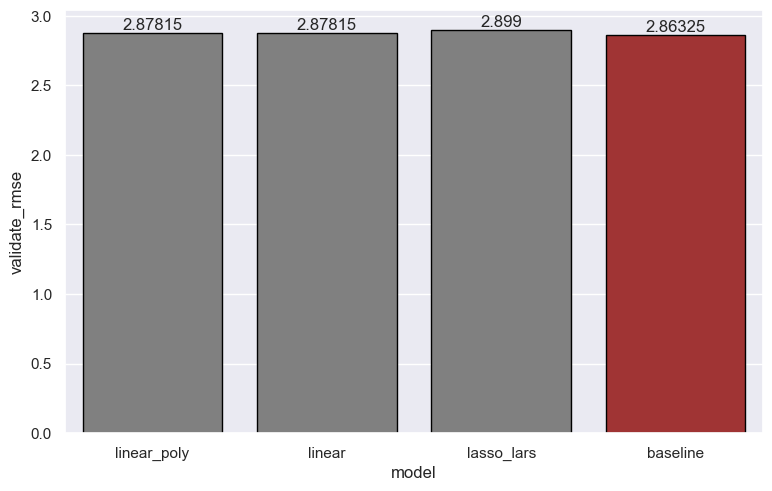

In [121]:
 def plot_model():
        
    color= ['grey', 'grey', 'grey', 'firebrick']
    ax = sns.barplot(x='model', y='validate_rmse',
                 data= best_mods,
                 palette= color,
                 errwidth=0, ec= 'black')
    for i in ax.containers:
        ax.bar_label(i,)
plot_model()

In [92]:
def best_model(X_train, y_train, X_val, y_val, X_test, y_test):
    
    df = best_models(X_train, y_train, X_val, y_val).iloc[1]
    
    df['test_rmse'] = test_model(X_train, y_train, X_test, y_test)
    
    df = pd.DataFrame(df).T
    
    #df = df.drop(columns = ['difference'])

    return df
test_mod= best_model(X_train, y_train, X_val, y_val, X_test, y_test)

In [88]:
best_mods.difference= best_mods.difference.astype(float)
best